# CtF-Game Policy Tournament

- Simple script to test the performance of individual policy.
- Graph the success reward, and episode length.
- Script __does not__ include the rendering

## TODO:


In [1]:
import os

import time
import gym
import gym_cap
import numpy as np

from collections import defaultdict
from matplotlib import pyplot as plt

# the modules that you can use to generate the policy.
import policy.zeros
import policy.patrol # only for non-stochastic zone? 
import policy.random
import policy.roomba # Supposed to be heuristic
import policy.policy_RL # RL weights are in ./model directory

# custom utilities
from utility.utils import MovingAverage as MA

## Policy/Model Selection

In [2]:
#rl_model = ['./model/'+name for name in os.listdir('./model')]
rl_model = ['./model/'+name for name in ('B4R4_Rzero_VANILLA', 'B4R4_self_VANILLA')]
rl_nick = ['red-zero train', 'self-play']

## Training Settings

In [3]:
env = gym.make("cap-v0") # initialize the environment

n_episode   = 100
ep_max      = 150
map_size    = 20
moving_ave  = 10
base_policy = [policy.zeros, policy.random]
base_nick = ['zero', 'random']

path exist
INFO:tensorflow:Restoring parameters from ./model/B4R4_Rzero_VANILLA/ctf_policy.ckpt-517999
Graph is succesfully loaded. ./model/B4R4_Rzero_VANILLA/ctf_policy.ckpt-517999
path exist
INFO:tensorflow:Restoring parameters from ./model/B4R4_self_VANILLA/ctf_policy.ckpt-506999
Graph is succesfully loaded. ./model/B4R4_self_VANILLA/ctf_policy.ckpt-506999
path exist
INFO:tensorflow:Restoring parameters from ./model/B4R4_Rzero_VANILLA/ctf_policy.ckpt-517999
Graph is succesfully loaded. ./model/B4R4_Rzero_VANILLA/ctf_policy.ckpt-517999
path exist
INFO:tensorflow:Restoring parameters from ./model/B4R4_self_VANILLA/ctf_policy.ckpt-506999
Graph is succesfully loaded. ./model/B4R4_self_VANILLA/ctf_policy.ckpt-506999


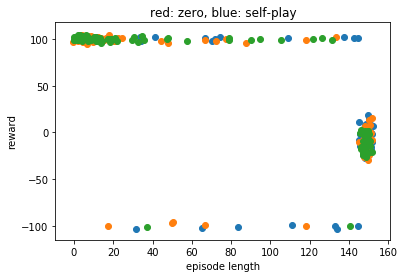

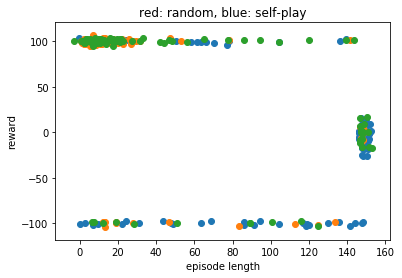

In [4]:
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# Measure Control Policies
ctrl_policy = [policy.random]
ctrl_nick = ['random']

for base_name, r_policy in zip(base_nick, base_policy):
    policy_red = r_policy.PolicyGen(env.get_map, env.get_team_red)
    plt.figure()
    # Control Policies
    for policy_name, b_policy in zip(ctrl_nick, ctrl_policy):
        policy_blue = b_policy.PolicyGen(env.get_map, env.get_team_blue)
        # reset the environment and select the policies for each of the team
        observation = env.reset(map_size=map_size,
                                policy_blue=policy_blue,
                                policy_red=policy_red)
        reward_table = []
        length_table = []
        for _ in range(n_episode):
            total_reward = 0
            prev_reward = 0
            for frame in range(ep_max):
                action = policy_blue.gen_action(env.get_team_blue, env._env)
                #observation, reward, done, info = env.step(action)
                observation, reward, done, info = env.step()  # feedback from environment
                r = reward-prev_reward
                total_reward += r
                prev_reward = reward
                if done:
                    break            
            reward_table.append(total_reward)
            length_table.append(frame)
            env.reset()
        
        reward_table = np.array(reward_table)
        length_table = np.array(length_table)

        plt.scatter(rand_jitter(length_table), rand_jitter(reward_table))
        plt.title(f'red: {base_name}, blue: {policy_name}')
        #plt.legend(ctrl_nick+rl_nick)
        plt.xlabel('episode length')
        plt.ylabel('reward')
        
        
    # RL Policies
    for policy_name, weight_dir in zip(rl_nick, rl_model):
        policy_blue = policy.policy_RL.PolicyGen(env.get_map, env.get_team_blue,model_dir=weight_dir,color='blue')
    
        reward_table = []
        length_table = []
        # reset the environment and select the policies for each of the team
        observation = env.reset(map_size=map_size,
                                policy_blue=policy_blue,
                                policy_red=policy_red)
        for _ in range(n_episode):
            total_reward = 0
            prev_reward = 0
            for frame in range(ep_max):
                action = policy_blue.gen_action(env.get_team_blue, env._env)
                observation, reward, done, info = env.step(action)
                #observation, reward, done, info = env.step()  # feedback from environment
                r = reward-prev_reward
                total_reward += r
                prev_reward = reward
                if done:
                    break            
            reward_table.append(total_reward)
            length_table.append(frame)
            env.reset()
        

        plt.scatter(rand_jitter(length_table), rand_jitter(reward_table))
        plt.title(f'red: {base_name}, blue: {policy_name}')
        #plt.legend(ctrl_nick+rl_nick)
        plt.xlabel('episode length')
        plt.ylabel('reward')

## Red :  zero-trained policy, Blue :Self-play policy

In [5]:
policy_red  = policy.policy_RL.PolicyGen(env.get_map, env.get_team_red ,model_dir=rl_model[0],color= 'red')
policy_blue = policy.policy_RL.PolicyGen(env.get_map, env.get_team_blue,model_dir=rl_model[1],color='blue')

blue_table = []
red_table  = []
draw_table = []
# reset the environment and select the policies for each of the team
s = env.reset(map_size=map_size,
                        policy_blue=policy_blue,
                        policy_red=policy_red)
for _ in range(n_episode):
    total_reward = 0
    prev_reward = 0
    for frame in range(ep_max):
        action = policy_blue.gen_action(env.get_team_blue, env._env)
        s, reward, done, info = env.step(action)
        #s, reward, done, info = env.step()  # feedback from environment
        r = reward-prev_reward
        total_reward += r
        prev_reward = reward
        if done or frame==ep_max-1:
            if env.blue_win:
                blue_table.append((frame, total_reward))
            elif env.red_win:
                red_table.append((frame, total_reward))
            else:
                draw_table.append((frame, total_reward))
            break
    env.reset()
print(f'blue won: {len(blue_table)}')
print(f'red won: {len(red_table)}')
print(f'draw : {len(draw_table)}')

'''plt.figure()
plt.scatter(rand_jitter(length_table), rand_jitter(reward_table))
plt.title(f'red: {base_name}')
plt.legend(ctrl_nick+rl_nick)
plt.xlabel('episode length')
plt.ylabel('reward')'''

path exist
INFO:tensorflow:Restoring parameters from ./model/B4R4_Rzero_VANILLA/ctf_policy.ckpt-517999
Graph is succesfully loaded. ./model/B4R4_Rzero_VANILLA/ctf_policy.ckpt-517999
path exist
INFO:tensorflow:Restoring parameters from ./model/B4R4_self_VANILLA/ctf_policy.ckpt-507999
Graph is succesfully loaded. ./model/B4R4_self_VANILLA/ctf_policy.ckpt-507999
blue won: 61
red won: 20
draw : 19


"plt.figure()\nplt.scatter(rand_jitter(length_table), rand_jitter(reward_table))\nplt.title(f'red: {base_name}')\nplt.legend(ctrl_nick+rl_nick)\nplt.xlabel('episode length')\nplt.ylabel('reward')"

## Red : Self-play policy, Blue : zero-trained policy (flipped color)

In [6]:
policy_red  = policy.policy_RL.PolicyGen(env.get_map, env.get_team_red ,model_dir=rl_model[1],color= 'red')
policy_blue = policy.policy_RL.PolicyGen(env.get_map, env.get_team_blue,model_dir=rl_model[0],color='blue')

blue_table = []
red_table  = []
draw_table = []
# reset the environment and select the policies for each of the team
s = env.reset(map_size=map_size,
                        policy_blue=policy_blue,
                        policy_red=policy_red)
for _ in range(n_episode):
    total_reward = 0
    prev_reward = 0
    for frame in range(ep_max):
        action = policy_blue.gen_action(env.get_team_blue, env._env)
        s, reward, done, info = env.step(action)
        #s, reward, done, info = env.step()  # feedback from environment
        r = reward-prev_reward
        total_reward += r
        prev_reward = reward
        if done or frame==ep_max-1:
            if env.blue_win:
                blue_table.append((frame, total_reward))
            elif env.red_win:
                red_table.append((frame, total_reward))
            else:
                draw_table.append((frame, total_reward))
            break
    env.reset()
print(f'blue won: {len(blue_table)}')
print(f'red won: {len(red_table)}')
print(f'draw : {len(draw_table)}')

'''plt.figure()
plt.scatter(rand_jitter(length_table), rand_jitter(reward_table))
plt.title(f'red: {base_name}')
plt.legend(ctrl_nick+rl_nick)
plt.xlabel('episode length')
plt.ylabel('reward')'''

path exist
INFO:tensorflow:Restoring parameters from ./model/B4R4_self_VANILLA/ctf_policy.ckpt-507999
Graph is succesfully loaded. ./model/B4R4_self_VANILLA/ctf_policy.ckpt-507999
path exist
INFO:tensorflow:Restoring parameters from ./model/B4R4_Rzero_VANILLA/ctf_policy.ckpt-518999
Graph is succesfully loaded. ./model/B4R4_Rzero_VANILLA/ctf_policy.ckpt-518999
blue won: 44
red won: 46
draw : 10


"plt.figure()\nplt.scatter(rand_jitter(length_table), rand_jitter(reward_table))\nplt.title(f'red: {base_name}')\nplt.legend(ctrl_nick+rl_nick)\nplt.xlabel('episode length')\nplt.ylabel('reward')"